In [24]:
# initializations
%matplotlib notebook
import matplotlib
# make figures smaller
matplotlib.rc('figure', figsize=(5, 3.75))
import matplotlib.pyplot as plt

import numpy.linalg
from scipy.optimize import leastsq
from diffpy.srfit.fitbase import FitRecipe, FitResults
from diffpy.srreal.pdfcalculator import PDFCalculator
from pyobjcryst import loadCrystal
from cdse_functions import differenceplot  #FIXME

## PDF refinement of CdSe naphthalene

We have x-ray PDF data measured crystallized naphthalene molecules.
Here we show the signal carries intra and inter-molecular contributions, how to model them and how to refine molecular orientation.

## Simple PDF fit

First we set up PDF model that uses uniform isotropic displacements for all carbon atoms.

In [25]:
# GLOBAL CONSTANTS
c_crystalfile = 'naphthalene.cif'
c_pdfdatafile = 'naphthalene.gr'
c_fitrange = (1.1, 20)
c_qdamp = 0.06
c_bisoinitial = 0.5

In [26]:
def best_scale(ysim, yobs):
    "Return the best least-squares scaling of ysim that approximates yobs"
    sc = numpy.dot(yobs, ysim) / numpy.dot(ysim, ysim)
    return sc


def load_crystal_common_biso():
    from pyobjcryst.crystal import CreateCrystalFromCIF
    fp = open(c_crystalfile, 'rb')
    # oneScatteringPowerPerElement sets all Carbons to have the same Biso
    crst = CreateCrystalFromCIF(fp, oneScatteringPowerPerElement=True)
    fp.close()
    a = crst.GetScatterer(0)
    spa = a.GetScatteringPower()
    spa.Biso = c_bisoinitial
    return crst

    
def load_molecular_crystal():
    """Load the CIF file and group all scatterers as one Molecule.

    This assumes the asymmetric unit is a single whole Molecule,
    i.e., there are no other molecules or independent atoms in
    the crystal and the molecule does not need to be
    symmetry-expanded.
    """
    crst = load_crystal_common_biso()
    from pyobjcryst.molecule import Molecule
    # center of the molecule in fractional coordinates
    xyzmol = np.array([0.0, 0.0, 0.0])
    # move all Atoms from the Crystal to its rigid Molecule
    mol = Molecule(crst, "mol")
    atoms = [crst.GetScatterer(i) for i in range(crst.GetNbScatterer())]
    for a in atoms:
        xyzm = np.array([a.X, a.Y, a.Z]) - xyzmol
        xc, yc, zc = crst.FractionalToOrthonormalCoords(*xyzm)
        mol.AddAtom(xc, yc, zc, a.GetScatteringPower(), a.GetName())
        crst.RemoveScatterer(a)
    crst.AddScatterer(mol)
    mol.X, mol.Y, mol.Z = xyzmol
    return crst, mol

if 0:
    # check if molecular crystal is the same as the original
    nph0 = load_crystal_common_biso()
    nph1 = load_molecular_crystal()[0]
    pc = PDFCalculator()
    fig, ax = plt.subplots(num=1)
    r0, g0 = pc(nph0)
    r1, g1 = pc(nph1)
    ax.plot(r0, g0, r1, g1 + 0.5)
pass

In [27]:
def new_simple_fit():
    from diffpy.srfit.pdf import PDFContribution
    gtot = PDFContribution('gtot')
    gtot.qdamp = c_qdamp
    gtot.loadData(c_pdfdatafile)
    crst = load_crystal_common_biso()
    gtot.addStructure('nph', crst)
    gtot.profile.setCalculationRange(*c_fitrange)
    fit = FitRecipe()
    fit.clearFitHooks()
    fit.addContribution(gtot)
    sc0 = best_scale(gtot.evaluate(), gtot.profile.y)
    fit.addVar(gtot.scale, value=sc0)
    ph = gtot.nph.phase
    # cell parameters
    fit.addVar(ph.a)
    fit.addVar(ph.b)
    fit.addVar(ph.c)
    # pyobjcryst stores cell angles in radians.  we will use degrees
    beta0 = np.degrees(ph.beta.value)
    fit.newVar('beta', value=beta0)
    fit.constrain(ph.beta, 'radians(beta)')
    # all carbon species have the same displacement parameter,
    # it is thus sufficient to do constrain for the first atom
    fit.addVar(ph.C1.Biso, name='BisoC', value=c_bisoinitial)
    return fit

#new_simple_fit().show()

In [28]:
fsimple = new_simple_fit()
leastsq(fsimple.residual, fsimple.values)
differenceplot(fsimple, fig=1, title='simple PDF refinement');

<IPython.core.display.Javascript object>

In [30]:
ressimple = FitResults(fsimple)
print("Rw =", ressimple.rw)

Rw = 0.5223799264637689


In [73]:
def fixqzero(q1, q2, q3):
    ssq = q1**2 + q2**2 + q3**2
    q0 = np.sqrt(1.0 - ssq) if ssq < 1 else 0.0
    return q0

def new_fancy_fit():
    from diffpy.srfit.pdf import PDFContribution
    gtot = PDFContribution('gtot')
    gtot.qdamp = c_qdamp
    gtot.loadData(c_pdfdatafile)
    gtot.profile.setCalculationRange(*c_fitrange)
    crst, mol = load_molecular_crystal()
    # contribution from single molecule
    gtot.addStructure('mol', mol, periodic=False)
    # inter-molecular wide-peak contributions
    wcrst, _ = load_molecular_crystal()
    _, wmol = load_molecular_crystal()
    gtot.addStructure('wcrst', wcrst, periodic=True)
    gtot.addStructure('wmol', wmol, periodic=False)
    gtot.setEquation('scale * (mol + wcrst - wmol)')
    fit = FitRecipe()
    fit.clearFitHooks()
    fit.addContribution(gtot)
    sc0 = best_scale(gtot.evaluate(), gtot.profile.y)
    fit.addVar(gtot.scale, value=sc0)
    wph = gtot.wcrst.phase
    # cell parameters
    fit.addVar(wph.a)
    fit.addVar(wph.b)
    fit.addVar(wph.c)
    # pyobjcryst stores cell angles in radians.  we will use degrees
    beta0 = np.degrees(wph.beta.value)
    fit.newVar('beta', value=beta0)
    fit.constrain(wph.beta, 'radians(beta)')
    # use BisoC for intra-molecular displacements of carbon
    fit.addVar(gtot.mol.phase.C1.Biso, name='BisoC', value=c_bisoinitial)
    # use BisoM for big molecule-to-molecule displacements
    fit.addVar(gtot.wcrst.phase.mol.C1.Biso, name='BisoM', 
               value=10*c_bisoinitial)
    fit.constrain(gtot.wmol.phase.C1.Biso, 'BisoM')
    # use mq1, ..., for orientation quaternion
    pwmol = gtot.wcrst.phase.mol
    fit.addVar(pwmol.q1, name='mq1')
    fit.addVar(pwmol.q2, name='mq2')
    fit.addVar(pwmol.q3, name='mq3')
    fit.registerFunction(fixqzero, argnames=['mq1', 'mq2', 'mq3'])
    fit.constrain(pwmol.q0, 'fixqzero(mq1, mq2, mq3)')
    return fit

#new_fancy_fit().show()

## Fit corrected for intra and intermolecular contributions

The fit is controlled by 2 displacement parameters - 
BisoM for inter molecular displacements and
BisoC for displacements within the same molecule.

<IPython.core.display.Javascript object>


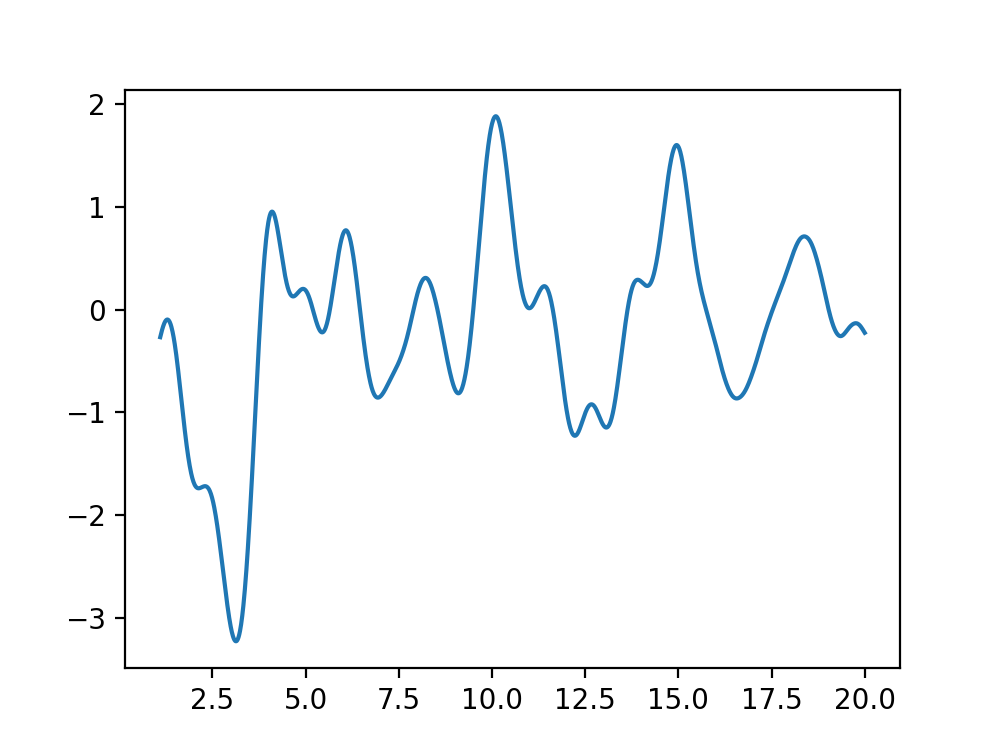

In [80]:
ffancy = new_fancy_fit()
ffancy.residual()
fig, ax = plt.subplots(num=3)
r = ffancy.gtot.profile.x
ax.plot(r, ffancy.gtot.evaluateEquation('wcrst - wmol'));